In [49]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
import time
import datetime
from scipy import stats
from datetime import date
from datetime import time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.svm import SVC

[Section ML](#section_ml)

## Load data

In [50]:
original_df = pd.read_csv('Data-Collisions.csv')
original_df.head()

/home/mathilde/anaconda3/envs/data_labs_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [51]:
print(len(original_df))
original_df.info()

194673
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 38 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SEVERITYCODE    194673 non-null  int64  
 1   X               189339 non-null  float64
 2   Y               189339 non-null  float64
 3   OBJECTID        194673 non-null  int64  
 4   INCKEY          194673 non-null  int64  
 5   COLDETKEY       194673 non-null  int64  
 6   REPORTNO        194673 non-null  object 
 7   STATUS          194673 non-null  object 
 8   ADDRTYPE        192747 non-null  object 
 9   INTKEY          65070 non-null   float64
 10  LOCATION        191996 non-null  object 
 11  EXCEPTRSNCODE   84811 non-null   object 
 12  EXCEPTRSNDESC   5638 non-null    object 
 13  SEVERITYCODE.1  194673 non-null  int64  
 14  SEVERITYDESC    194673 non-null  object 
 15  COLLISIONTYPE   189769 non-null  object 
 16  PERSONCOUNT     194673 non-null  int64  
 17  PED

In [61]:
original_df['EXCEPTRSNDESC'].value_counts()

Not Enough Information, or Insufficient Location Information    5638
Name: EXCEPTRSNDESC, dtype: int64

In [52]:
original_df['SEVERITYCODE.1'].value_counts()

1    136485
2     58188
Name: SEVERITYCODE.1, dtype: int64

In [53]:
original_df['SEVERITYCODE'].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

In [54]:
original_df['SEVERITYDESC'].value_counts()

Property Damage Only Collision    136485
Injury Collision                   58188
Name: SEVERITYDESC, dtype: int64

#  1) <u> Data Exploration  </u>

## 1a) Data preprocessing

### Outliers

### Missing values

### Feature engineering

## 1b) Data Visualization

### Alcohol analysis

In [55]:
df = original_df.copy()

In [56]:
# Transform into datetime format
df['INCDTTM_rework'] = pd.to_datetime(df['INCDTTM'])

# Split dates and times
df['DATES'] = pd.to_datetime(df['INCDTTM_rework']).dt.date
df['TIME'] = pd.to_datetime(df['INCDTTM_rework']).dt.time

# Extract month and weekday
df['MONTH'] = df['INCDTTM_rework'].dt.strftime('%b')
df['DAY'] = df['INCDTTM_rework'].dt.strftime('%a')


In [59]:
df['DATES'].max()

datetime.date(2020, 5, 20)

In [10]:
# Create variables to split times into categories

night = time.fromisoformat('21:00:00')
night_end_day = time.fromisoformat('23:59:59')
late_night = time.fromisoformat('00:01:00')
rush_am = time.fromisoformat('07:00:00')
empty_am = time.fromisoformat('09:00:00')
lunch = time.fromisoformat('12:00:00')
empty_pm = time.fromisoformat('13:00:00')
rush_pm = time.fromisoformat('17:00:00')
afterwork = time.fromisoformat('18:00:00')


def get_cat_hour(x) :
    """Function that categorizes hours into categories of different moments of the day
    Takes a time and return a different period of time during the day. 
    Periods of the day are defined above"""
    if x >= late_night and x < rush_am :
        return 'mid_night'
    elif x >= rush_am and x < empty_am : 
        return 'rush_am'
    elif x >= empty_am and x < lunch :
        return 'morning'
    elif x >= lunch and x < empty_pm :
        return 'lunch'
    elif x >= empty_pm and x < rush_pm :
        return 'afternoon'
    elif x >= rush_pm and x < afterwork :
        return 'rush_pm'
    elif x >= afterwork and x < night :
        return 'evening'
    elif x >= night and x < night_end_day :
        return 'night'
    else :
        return 'unknown'
        

In [11]:
# Apply the function get_cat_hour to the column TIME
df['MOMENT_OF_DAY'] = df['TIME'].apply(get_cat_hour)

In [12]:
def get_cat_day(x) : 
    if x == 'Sat' or x == 'Sun':
        return 'Weekend'
    else :
        return 'weekday'

In [13]:
# Apply the function get_cat_day to the column DAY
df['WKDAY'] = df['DAY'].apply(get_cat_day)


In [14]:
df[df['INTKEY'] > 20]

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,INCDTTM_rework,DATES,TIME,MONTH,DAY,MOMENT_OF_DAY,WKDAY
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,0,0,N,2013-03-27 14:54:00,2013-03-27,14:54:00,Mar,Wed,afternoon,weekday
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,0,0,N,2004-01-28 08:04:00,2004-01-28,08:04:00,Jan,Wed,rush_am,weekday
5,1,-122.387598,47.690575,6,320840,322340,E919477,Matched,Intersection,36974.0,...,0,0,N,2019-04-20 17:42:00,2019-04-20,17:42:00,Apr,Sat,rush_pm,Weekend
6,1,-122.338485,47.618534,7,83300,83300,3282542,Matched,Intersection,29510.0,...,0,0,N,2008-12-09 00:00:00,2008-12-09,00:00:00,Dec,Tue,unknown,weekday
7,2,-122.320780,47.614076,9,330897,332397,EA30304,Matched,Intersection,29745.0,...,6855,0,N,2020-04-15 17:47:00,2020-04-15,17:47:00,Apr,Wed,rush_pm,weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194656,2,-122.340474,47.614496,219524,312179,313599,E885580,Matched,Intersection,29545.0,...,0,523322,N,2019-01-23 10:15:00,2019-01-23,10:15:00,Jan,Wed,morning,weekday
194664,1,-122.325887,47.643191,219537,309222,310502,E879537,Matched,Intersection,28300.0,...,0,0,N,2018-12-30 15:25:00,2018-12-30,15:25:00,Dec,Sun,afternoon,Weekend
194665,1,-122.304217,47.669537,219538,308480,309760,3642620,Matched,Intersection,26005.0,...,0,0,N,2018-12-05 13:00:00,2018-12-05,13:00:00,Dec,Wed,afternoon,weekday
194670,2,-122.306689,47.683047,219545,311280,312640,3809984,Matched,Intersection,24760.0,...,0,0,N,2019-01-19 09:25:00,2019-01-19,09:25:00,Jan,Sat,morning,Weekend


In [15]:
mask = df['INTKEY'] > 20
df['INTKEY'][mask]

0         37475.0
4         34387.0
5         36974.0
6         29510.0
7         29745.0
           ...   
194656    29545.0
194664    28300.0
194665    26005.0
194670    24760.0
194671    24349.0
Name: INTKEY, Length: 65070, dtype: float64

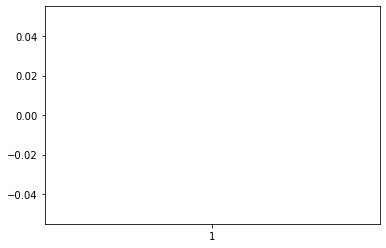

In [16]:
# boxplot 
intkey_data = list(df['INTKEY'])
data = intkey_data 
plt.boxplot(data)

plt.show()

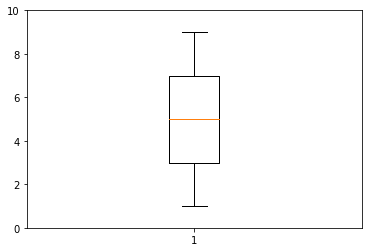

In [17]:
 data = [1,2,3,4,5,6,7,8,9]

 plt.boxplot(data)

 plt.ylim(0,10)

 plt.savefig('SimpleBoxPlot.png')
 plt.show()

## Data cleaning

In [18]:
# List all columns with no useful information
useless_col = ['OBJECTID','INCKEY','COLDETKEY','REPORTNO','LOCATION','EXCEPTRSNCODE',
                   'EXCEPTRSNDESC','SEVERITYCODE.1','SEVERITYDESC','INCDATE',
                   'CROSSWALKKEY', 'SEGLANEKEY']

# List of continuous features
cont_cols = ['X','Y','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT']

# List of categorical features
cat_cols = [ x for x in df.columns if x not in cont_cols if x not in useless_col if x!= 'SEVERITYCODE']

In [19]:
# List of columns with too many missing values (20% of missing values and more)
missing_values = (df.isnull().sum() / len(df)) >= 0.20 
col_too_many_missing = missing_values[missing_values==True].index

# Delete columns with too many missing values
df = df[[ x for x in list(df.columns) if x not in col_too_many_missing ]]
df.columns

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'LOCATION', 'SEVERITYCODE.1', 'SEVERITYDESC',
       'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT',
       'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'ST_COLCODE',
       'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR',
       'INCDTTM_rework', 'DATES', 'TIME', 'MONTH', 'DAY', 'MOMENT_OF_DAY',
       'WKDAY'],
      dtype='object')

In [20]:
useless_col.extend(['INCDTTM', 'INCDTTM_rework', 'DATES', 'TIME', 'MONTH', 'DAY' ])
# Delete all not useful columns
df = df[[x for x in list(df.columns) if x not in useless_col]]

In [21]:
df.columns

Index(['SEVERITYCODE', 'X', 'Y', 'STATUS', 'ADDRTYPE', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'JUNCTIONTYPE',
       'SDOT_COLCODE', 'SDOT_COLDESC', 'UNDERINFL', 'WEATHER', 'ROADCOND',
       'LIGHTCOND', 'ST_COLCODE', 'ST_COLDESC', 'HITPARKEDCAR',
       'MOMENT_OF_DAY', 'WKDAY'],
      dtype='object')

In [22]:
# Fillna with mean for continuous columns
for col in cont_cols :
    if col in df.columns: 
        df[col] = df[col].fillna(df[col].mean())
        
# Fillna with mode (highest frequency) for cat columns
for col in cat_cols : 
    if col in df.columns :
        df[col] = df[col].fillna(df[col].mode()[0])

In [23]:
df.columns

Index(['SEVERITYCODE', 'X', 'Y', 'STATUS', 'ADDRTYPE', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'JUNCTIONTYPE',
       'SDOT_COLCODE', 'SDOT_COLDESC', 'UNDERINFL', 'WEATHER', 'ROADCOND',
       'LIGHTCOND', 'ST_COLCODE', 'ST_COLDESC', 'HITPARKEDCAR',
       'MOMENT_OF_DAY', 'WKDAY'],
      dtype='object')

In [24]:
import matplotlib.pyplot as plt

In [25]:
nonan = df['UNDERINFL'].dropna().sample(1000)

Text(0.5, 1.0, "Exemple d' histogramme simple")

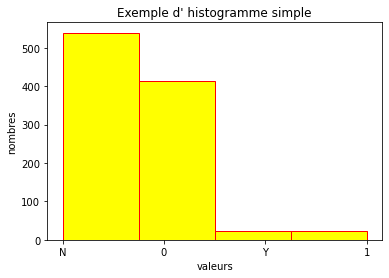

In [26]:
x = list(nonan)
plt.hist(x,  bins = 4, color = 'yellow',
            edgecolor = 'red')
plt.xlabel('valeurs')
plt.ylabel('nombres')
plt.title('Exemple d\' histogramme simple')

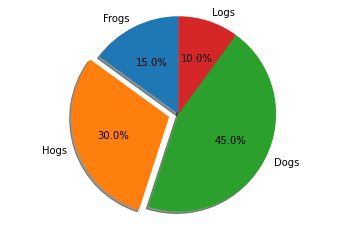

In [27]:

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
sizes = [15, 30, 45, 10]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [28]:
severe_accidents = df[df['SEVERITYCODE'] == 2]
underinfl_severe = severe_accidents['UNDERINFL'].value_counts()
list(underinfl_severe.values)

[31925, 22701, 1939, 1623]

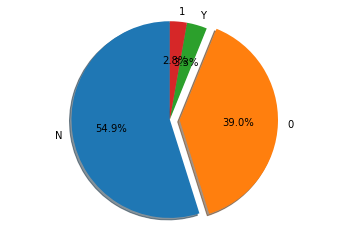

In [29]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = list(underinfl_severe.index)
sizes = list(underinfl_severe.values)
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [30]:
# boxplot 
#data = df['INTKEY']

#plt.boxplot(data)

#plt.show()

In [31]:
from scipy.stats import pearsonr

def get_pearson_score(df,cols) :
    pearson_scores = []
    cols = [x for x in cols if x in df.columns ]

    for i in range(len(cols)) : 
        for j in range(i+1, len(cols)) :
            if i !=j :
                x = pearsonr(df[cols[i]], df[cols[j]])[0]
                pearson_scores.append([cols[i],cols[j],x])
    pearson_scores = pd.DataFrame(pearson_scores, columns = ['col_a', 'col_b', 'pearson'])
    pearson_scores.sort_values(by = 'pearson', ascending = False, inplace= True)
    return pearson_scores

In [32]:
get_pearson_score(df, cont_cols)

,col_a,col_b,pearson
11,PERSONCOUNT,VEHCOUNT,0.380523
7,Y,PEDCYLCOUNT,0.026209
8,Y,VEHCOUNT,0.016793
1,X,PERSONCOUNT,0.012739
2,X,PEDCOUNT,0.011256
6,Y,PEDCOUNT,0.010134
3,X,PEDCYLCOUNT,-0.001746
4,X,VEHCOUNT,-0.011979
5,Y,PERSONCOUNT,-0.013691
12,PEDCOUNT,PEDCYLCOUNT,-0.016920


#  2) <u> Correlation analysis & feature selection </u>

## 2a) Correlations among features

### Continuous variables

### Categorical variables

## 2b) Correlations with target variable

## 2c) Getting dummies of categorical variables

In [33]:
def cramers_v(x, y):
    
    """Statistical test to compute the association between two categorical variables """
    
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [34]:
def get_cramer_score(df,cols) :
    cramers_scores = []
    cols = [x for x in cols if x in df.columns ]

    for i in range(len(cols)) : 
        for j in range(i+1, len(cols)) :
            if i !=j :
                x = cramers_v(df[cols[i]], df[cols[j]])
                cramers_scores.append([cols[i],cols[j],x])
    cramers_scores = pd.DataFrame(cramers_scores, columns = ['col_a', 'col_b', 'cramers'])
    cramers_scores.sort_values(by = 'cramers', ascending = False, inplace= True)
    return cramers_scores
    

In [35]:
get_cramer_score(df, cat_cols)

,col_a,col_b,cramers
50,SDOT_COLCODE,SDOT_COLDESC,1.000000
35,COLLISIONTYPE,ST_COLDESC,0.999866
95,ST_COLCODE,ST_COLDESC,0.999864
34,COLLISIONTYPE,ST_COLCODE,0.999730
9,STATUS,ST_COLCODE,0.998975
...,...,...,...
11,STATUS,HITPARKEDCAR,0.020095
89,ROADCOND,WKDAY,0.019594
13,STATUS,WKDAY,0.019435
26,ADDRTYPE,WKDAY,0.013092


In [36]:
res = get_cramer_score(df, cat_cols)

for row in res.iterrows():
    print(row[1])
    print()
    print()

col_a      SDOT_COLCODE
col_b      SDOT_COLDESC
cramers               1
Name: 50, dtype: object


col_a      COLLISIONTYPE
col_b         ST_COLDESC
cramers         0.999866
Name: 35, dtype: object


col_a      ST_COLCODE
col_b      ST_COLDESC
cramers      0.999864
Name: 95, dtype: object


col_a      COLLISIONTYPE
col_b         ST_COLCODE
cramers          0.99973
Name: 34, dtype: object


col_a          STATUS
col_b      ST_COLCODE
cramers      0.998975
Name: 9, dtype: object


col_a          ADDRTYPE
col_b      JUNCTIONTYPE
cramers         0.70575
Name: 15, dtype: object


col_a      COLLISIONTYPE
col_b       SDOT_COLDESC
cramers         0.587915
Name: 29, dtype: object


col_a      COLLISIONTYPE
col_b       SDOT_COLCODE
cramers         0.587915
Name: 28, dtype: object


col_a        ADDRTYPE
col_b      ST_COLCODE
cramers      0.508031
Name: 22, dtype: object


col_a        ADDRTYPE
col_b      ST_COLDESC
cramers      0.503327
Name: 23, dtype: object


col_a           ADDRTYPE
col_b   

In [37]:
def get_cont_corr_with_target(df,cols) :
    pearson_scores_severity = []
    cols = [x for x in cols if x in df.columns ]

    for i in range(len(cols)) : 
        x = pearsonr(df[cols[i]], df['SEVERITYCODE'])[0]
        pearson_scores_severity.append([cols[i],x])
    pearson_scores_severity = pd.DataFrame(pearson_scores_severity, columns = ['col_a', 'pearson'])
    pearson_scores_severity.sort_values(by = 'pearson', ascending = False, inplace= True)
    return pearson_scores_severity

In [38]:
get_cont_corr_with_target(df, cont_cols)

,col_a,pearson
3,PEDCOUNT,0.246338
4,PEDCYLCOUNT,0.214218
2,PERSONCOUNT,0.130949
1,Y,0.017538
0,X,0.010193
5,VEHCOUNT,-0.054686


In [39]:
def get_cat_corr_with_target(df,cols) :
    cramers_scores_severity = []
    cols = [x for x in cols if x in df.columns ]

    for i in range(len(cols)) : 
        x = cramers_v(df[cols[i]], df['SEVERITYCODE'])
        cramers_scores_severity.append([cols[i],x])
    cramers_scores_severity = pd.DataFrame(cramers_scores_severity, columns = ['col_a', 'cramers'])
    cramers_scores_severity.sort_values(by = 'cramers', ascending = False, inplace= True)
    return cramers_scores_severity

In [40]:
get_cat_corr_with_target(df, cat_cols)

,col_a,cramers
10,ST_COLCODE,0.474026
11,ST_COLDESC,0.470927
2,COLLISIONTYPE,0.458381
4,SDOT_COLCODE,0.382030
5,SDOT_COLDESC,0.382030
3,JUNCTIONTYPE,0.219315
1,ADDRTYPE,0.199791
8,ROADCOND,0.160892
7,WEATHER,0.159159
9,LIGHTCOND,0.155184


In [41]:
# Delete columns too correlated (> 0.6)
useless_col.extend(['ST_COLDESC', 'STATUS','SDOT_COLCODE', 'ADDRTYPE', 'ST_COLCODE'])
df = df[[x for x in list(df.columns) if x not in useless_col]]

In [42]:
# Get dummies
X= df[[x for x in list(df.columns) if x in cat_cols and x!= 'SEVERITYCODE']]
X = pd.get_dummies(X, prefix = [x for x in X.columns], columns = [x for x in X.columns])

y= df['SEVERITYCODE'].apply(lambda x : 0 if x==1 else 1)

In [43]:
get_pearson_score(X, X.columns)

,col_a,col_b,pearson
611,COLLISIONTYPE_Pedestrian,SDOT_COLDESC_MOTOR VEHCILE STRUCK PEDESTRIAN,0.958080
4662,WEATHER_Unknown,ROADCOND_Unknown,0.894112
4533,WEATHER_Raining,ROADCOND_Wet,0.767951
4340,WEATHER_Clear,ROADCOND_Dry,0.752000
4672,WEATHER_Unknown,LIGHTCOND_Unknown,0.731454
...,...,...,...
4963,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Daylight,-0.740755
4693,ROADCOND_Dry,ROADCOND_Wet,-0.800731
4117,UNDERINFL_0,UNDERINFL_N,-0.909079
5073,HITPARKEDCAR_N,HITPARKEDCAR_Y,-1.000000


In [44]:
#res1 = get_pearson_score(X, X.columns)

#for row in res1.iterrows():
#    print(row[1])
#   print()
#   print()


In [45]:
# Exclude correlated dummies
correlated_dummies = ['SDOT_COLDESC_MOTOR VEHCILE STRUCK PEDESTRIAN', 'WEATHER_Unknown', 'WEATHER_Raining', 
                      'ROADCOND_Dry', 'LIGHTCOND_Unknown', 
                      'SDOT_COLDESC_MOTOR VEHICLE STRUCK PEDALCYCLIST, FRONT END AT ANGLE',
                      'SDOT_COLDESC_MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END', 'WKDAY_Weekend', 
                      'HITPARKEDCAR_N',
                      'UNDERINFL_N', 'LIGHTCOND_Daylight', 'JUNCTIONTYPE_Mid-Block (not related to intersection)', 
                      'WEATHER_Clear', 'UNDERINFL_0']

X= X[[x for x in X.columns if x not in correlated_dummies]]

In [46]:
def get_corr_to_target(df,y) :
    pearson_scores_severity = []

    for col in df.columns : 
        x = pearsonr(df[col], y)[0]
        pearson_scores_severity.append([col,x])
    pearson_scores_severity = pd.DataFrame(pearson_scores_severity, columns = ['col_a', 'pearson'])
    pearson_scores_severity.sort_values(by = 'pearson', ascending = False, inplace= True)
    return pearson_scores_severity

In [47]:
get_corr_to_target(X,y)

,col_a,pearson
6,COLLISIONTYPE_Pedestrian,0.245441
1,COLLISIONTYPE_Cycles,0.213271
11,JUNCTIONTYPE_At Intersection (intersection rel...,0.201628
7,COLLISIONTYPE_Rear Ended,0.132313
42,SDOT_COLDESC_PEDALCYCLIST STRUCK MOTOR VEHICLE...,0.105309
...,...,...
39,SDOT_COLDESC_NOT ENOUGH INFORMATION / NOT APPL...,-0.113868
31,SDOT_COLDESC_MOTOR VEHICLE STRUCK MOTOR VEHICL...,-0.116066
9,COLLISIONTYPE_Sideswipe,-0.116638
68,ROADCOND_Unknown,-0.157748


In [48]:
#res1 = get_corr_to_target(X,y)

#for row in res1.iterrows():
#    print(row[1])
#    print()
#    print()

<a id='section_ml'></a>
# 3) <u>   Machine Learning </u>

## 3a) Model Selection

### Splitting the data

### Performing a gridsearch

### Rebalancing

## 3b) Model evaluation

### Performing cross validation

In [49]:
# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33,random_state=40)

In [50]:
xgb = XGBClassifier(n_jobs=-1)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
# We make predictions on the unseen Test data with the best estimator (Based on the gridsearch results)
preds=xgb.predict(X_test)

In [52]:
# accuracy score 
from sklearn.metrics import accuracy_score

In [53]:
accuracy_score(preds,y_test)

0.7531559858661644

In [54]:
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

           0       0.75      0.98      0.85     45069
           1       0.83      0.22      0.34     19174

    accuracy                           0.75     64243
   macro avg       0.79      0.60      0.60     64243
weighted avg       0.77      0.75      0.70     64243

[[44246   823]
 [15035  4139]]


In [55]:
pd.Series(preds).value_counts()

0    59281
1     4962
dtype: int64

In [56]:
pd.Series(y_train).value_counts()

0    91416
1    39014
Name: SEVERITYCODE, dtype: int64

In [57]:

# créer des visualisations - essayer heatmap? des correlations avec rouges si valeur a supprimé (touge)
# créer toutes les visualisations : 
#  - attribute vs. target
#  - autre fun target 

# 4) <u> Error analysis & interpretation <u>